### Libraries 

In [16]:
## installation of libraries
!pip install langdetect
!pip install selenium

  Using cached langdetect-1.0.8.tar.gz (981 kB)
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993196 sha256=1530ad731e6b7217fd5c05ee7962ee368d2f5eb3ecc3e24166a7dae28947a790
  Stored in directory: c:\users\francesco\appdata\local\pip\cache\wheels\59\f6\9d\85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
  Using cached selenium-3.141.0-py2.py3-none-any.whl (904 kB)


In [17]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
import pandas as pd
from tqdm import tqdm
from selenium import webdriver

import urllib
from langdetect import detect
import os
import numpy as np
import random
import string
import datetime

# ***1. Data collection***

In [2]:

# calling selenium firefox driver
driver = webdriver.Firefox(executable_path = r'D:\chrome\geckodriver-v0.26.0-win64\geckodriver.exe')

In [3]:
# Let's create dataframe with links of each book
df = pd.DataFrame(columns = ['Href'])

### 1.1. Get the list of books

In [4]:
# We will go page by page and and store links in dataframe
href = []
for i in tqdm(range(1, 301)):
    driver.get('https://www.goodreads.com/list/show/1.Best_Books_Ever?page=' + str(i))
    driver.find_element_by_tag_name('body').send_keys(Keys.END)
    soup = BeautifulSoup(driver.page_source)
    for url in soup.find_all('a', {'class':'bookTitle'}):
        string = 'https://www.goodreads.com/' + str(url.get('href'))
        href.append(string)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [43:41<00:00,  8.74s/it]


In [5]:
df['Href'] = href

In [6]:
df['Href'].nunique()

30000

In [7]:
# Let's save dataframe
df.to_csv('updated_url_30000.csv')

In [ ]:
# let's load the links we have from dataframe
df=pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/updated_url_30000.csv')
df.reset_index(drop = True, inplace = True)

### 1.2. Crawl books

#### So due to space constraint we have downloaded 10000 pages each and then we have merged it

In [ ]:
for idx, link in tqdm(enumerate(df['Href'][10001:20000])):
    urllib.request.urlretrieve (link, r"/content/drive/MyDrive/La_sapienza/ADM/html_data/{}_book_{}.html".format(link.split('/')[-1],str(idx)))

1264it [12:53,  1.63it/s]


### 1.3 Parse downloaded pages

In [ ]:
# let's create dataframe where we are going to save every thing we are going to crawl from html pages
df = pd.DataFrame(columns  = ['bookTitle','bookSeries', 'bookAuthors', 'ratingValue', 'Plot', 'ratingCount','reviewCount' ,'NumberofPages',
                              'PublishingDate', 'Characters','Setting', 'url'])

In [ ]:
bookTitle = []
bookSeries = []
bookAuthors = []
ratingValue = []
Plot = []
ratingCount = []
reviewCount = []
NumberofPages = []
PublishingDate = []
Characters = []
Setting = []
url = []

count_r =  1
for path, directories, files in os.walk(r'/content/drive/MyDrive/La_sapienza/ADM/html_data'):
  for idx, file in tqdm(enumerate(files[8000:])):
    # if count<5:
    #   print(path +'/'+ file)
    paths = path + '/' + file
    soup = BeautifulSoup(open(paths), features='lxml')
    #Plot  
    txt = ''
    # plot_text = soup.find_all('div', id = 'description')[0].contents[3].contents[0]
    try:
      txt = ''
      for k in soup.find_all('div', id = 'description')[0].find_all('span'):
        txt = txt + ' ' + k.text
    except:
      pass

    if len(txt) > 0 and detect(txt) == 'en' :  # check if lang of plot is english or not
      Plot.append(txt)
      
      #bookTitle
      # booktitle= soup.find_all('h1')[0].contents[0]
      try:
        booktitle = soup.find('h1', {'id': 'bookTitle'}).text.strip()  
        bookTitle.append(booktitle)
      except:
        bookTitle.append(np.nan)

      #bookSeries
      try:
        bkseries = soup.find('h2', {'id': 'bookSeries'}).find('a', {'class':'greyText'}).text.strip()
        bookSeries.append(bkseries)
      except:
        bookSeries.append(np.nan)


      #bookAuthors
      try:
        bauthor = []
        for el in soup.find_all('a', class_='authorName'):
            bauthor.append(el.string)
        bookAuthors.append(", ".join(bauthor))
      except:
        bookAuthors.append(np.nan)

      #ratingValue
      try:
        rv = soup.find('span', {'itemprop':'ratingValue'}).text.strip()
        # rv = soup.find_all('span', itemprop= 'ratingValue')[0].contents[0]
        ratingValue.append((' '.join(rv)))
      except:
        ratingValue.append(np.nan)

      #ratingCount
      try:
        rat =  soup.find('meta',{'itemprop':"ratingCount"}).get('content')
        # rat = soup.find('a', href="#other_reviews" ).contents[2].split()
        ratingCount.append(rat)  
      except:
        ratingCount.append(np.nan) 

      #reviewCount
      try:
        rew = soup.find('meta',{'itemprop':"reviewCount"}).get('content')
        # rew = soup.find_all('a', href="#other_reviews" )[1].contents[2].split()
        reviewCount.append(rew)
      except:
        reviewCount.append(np.nan)


      #NumberofPages
      try:
        pages = soup.find('span',{'itemprop':"numberOfPages"}).text
        # pages= soup.find_all('span', itemprop="numberOfPages")[0].contents[0]
        NumberofPages.append(pages)
      except:
        NumberofPages.append(np.nan)

      #PublishingDate
      try:
        date = soup.find_all('div',{'class':"row"})[1].text.strip()
        # date = soup.find_all('div', class_="row")[1].contents[0]
        PublishingDate.append(date)
      except:
        PublishingDate.append(np.nan)

      #Characters
      chrs = []
      try:
        for el in soup.select('a[href*=characters]'):
            chrs.append(el.string)
        Characters.append(chrs)
      except:
        Characters.append(np.nan)

      #Setting
      stg = []
      try:
        for el in soup.select('a[href*=places]'):
            stg.append(el.string)
        Setting.append(stg)
      except:
        Setting.append(np.nan)
      
      url_ = 'https://www.goodreads.com//book/show/' + "_".join(file.split('_')[:-2])
      url.append(url_)
    

2000it [15:29,  2.15it/s]


In [ ]:
df.bookTitle = bookTitle  
df.bookSeries = bookSeries
df.bookAuthors = bookAuthors
df.ratingValue = ratingValue
df.Plot = Plot
df.ratingCount = ratingCount
df.reviewCount = reviewCount
df.NumberofPages = NumberofPages
df.PublishingDate = PublishingDate
df.Characters = Characters
df.Setting = Setting 
df.url =url
df.to_csv(r'/content/drive/MyDrive/La_sapienza/ADM/data_final_3_2000.csv')

In [ ]:
df1 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/data_final_0_2000.csv')
df2 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/data_final_1_2000.csv')
df3 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/data_final_2_2000.csv')
df4 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/data_final_3_2000.csv')

In [ ]:
frame = [df1,df2,df3,df4]
result = pd.concat(frame, ignore_index=True)

In [ ]:
result.to_csv(r'/content/drive/MyDrive/La_sapienza/ADM/1st_10000_books.csv')

In [15]:
import urllib
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import json

In [3]:
df1 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/1st_10000_books.csv')
df2 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza/ADM/2st_10000_books.csv')
df3 = pd.read_csv(r'/content/drive/MyDrive/La_sapienza//ADM/3st_10000_books.csv')
frames = [df1, df2, df3]
df = pd.concat(frames, ignore_index=True)
df.reset_index(drop = True, inplace = True)

In [4]:
df.shape

(26452, 14)

# **2. Search Engine**

### Libraries for the search engine

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [8]:
ps = PorterStemmer()
stop_words = stopwords.words('english')

In [9]:
remove_punctuation = string.punctuation + '..' + '...' + "''" + "``"

For the search engine we first tokenize the plot, then we adjust some token which contains symbols or lower case letters.
After this we:
- Remove the punctuations
- do Stemming
- Remove digits
- Not consider the ripetitive token

In [10]:
def search_engine(plot):
    plot = re.sub(r'[^\w\s]', '', plot) 
    plot_tokens = nltk.word_tokenize(plot) #Tokenization
    plot_tokens_lower = []
    for e in plot_tokens:
        plot_tokens_lower.extend(re.split("—|-|'",e.lower()))#Lowercase and split the words which contains -
    plot2 = [w for w in plot_tokens_lower if not w.lower() in stop_words]#Removing Stopwords
    plot3 = [w for w in plot2 if not w in remove_punctuation] #Removing Punctuation
    plot4 = []
    for e in plot3:
        # e = e.replace('.','')
        plot4.append(ps.stem(e)) #Stemming
    plot5 = []
    for e in plot4:
        if e[0].isnumeric() == False:
            if e not in plot5:
                plot5.append(e)
    

    # for 
    # print("rocks :", lemmatizer.lemmatize("rocks")) 
      
    
    return plot5

Adding the column Plot_Token to df

In [11]:
from tqdm import tqdm
tqdm.pandas() 
df['Plot_Token'] = df['Plot'].progress_apply(lambda x: search_engine(x))

100%|██████████| 26452/26452 [01:44<00:00, 254.11it/s]


### 2.1.1) Create your index!

To create our inverse index we first store in the *words*  list all the token we have met tokenizing the plot. <br>
Then we sort by alphabetical order the list. <br>
In vocabulary we create a key-value relationship such that we have as a key the token and as a value the index of that particular word (this relationship is one to one since we have eliminated in words all the duplication) <br>
We store the vocabulary in a json file to not lose informations.

In [12]:
#storing all the possible word of our dictionary
words = []
for el in tqdm(df['Plot_Token']):
    for w in el:
        if w not in words:
            words.append(w) 

100%|██████████| 26452/26452 [07:04<00:00, 62.30it/s]


In [13]:
#sorting words in alphabetical order  
words=sorted(words)

In [14]:
vocabulary={}
for i in tqdm(range(len(words))):
    vocabulary.update({words[i]:i})

100%|██████████| 113861/113861 [00:00<00:00, 900923.15it/s]


In [16]:
#saving in a new variable this vocabulary
voc = vocabulary

In [17]:
#preparing the vocabulary and the list for the value 
vocabulary={}
for i in tqdm(range(len(words))):
    vocabulary.update({words[i] : [] }) #we are going to fill the list with the document id that contains that token

100%|██████████| 113861/113861 [00:00<00:00, 387400.56it/s]


In [18]:
# the json file where the output must be stored  
out_file = open(r'/content/drive/MyDrive/La_sapienza/ADM/vocabulary.json', "w")  
    
json.dump(vocabulary, out_file)  
    
out_file.close()  

In [19]:
out_file = open(r'/content/drive/MyDrive/La_sapienza/ADM/voc.json', "w")  
    
json.dump(voc, out_file)  
    
out_file.close()  

In [20]:
#preparing the list of document that contain token_j for each j
for idx,el in tqdm(enumerate(df['Plot_Token'])):
    for token in el:
        vocabulary[token].append(idx)

26452it [00:00, 28022.51it/s]


In [21]:
#store the inverse_index vocabulary in a json file
inverse_index = {}
for idx,el in tqdm(enumerate(df['Plot_Token'])):
    for token in el:
        inverse_index.update({voc[token] : vocabulary[token]})

26452it [00:01, 14956.55it/s]


In [23]:
# with open("r'/content/drive/MyDrive/La_sapienza/ADM/inverse_index.json", "w", encoding = "utf8") as v:
#     v.write(json.dumps(inverse_index)) #store the vocabulary in a json file

### 2.1.2) Execute the query

In this first part we are going to retrieve all the document that contains all the words of the query, to do this we look for the intersection among all the documents that contains at least one token of the query. In this way the intersection s will contain only the documents that present _every_ token of the query

In [24]:
q = 'World War'

In [25]:
# to be consistent we apply the search engine functions on the text query 
new_query = search_engine(q)

In [26]:
s = set(inverse_index[voc[new_query[0]]])#in order to do the intersection we don't want an empty set in the beginning
                                            #so we fill s with the documents that contains the first token of q
for w in tqdm(new_query):
    s = s.intersection(set(inverse_index[voc[w]]))

100%|██████████| 2/2 [00:00<00:00, 421.28it/s]


In [27]:
#selecting all the document from df that contains all the token of q
out = df.iloc[list(s)]

In [28]:
#the output is sorted by document_id
out.sort_index()[['bookTitle','Plot','url']]

,bookTitle,Plot,url
3,The Winter of the Witch,Following their adventures in The Bear and th...,https://www.goodreads.com//book/show/36621586-...
17,Polgara the Sorceress,"She soars above a world of warriors, kings, a...",https://www.goodreads.com//book/show/18884.Pol...
47,THE DIARY OF A CANADIAN NOBODY: The diary of a...,It's September 2001 and Arthur Lakelady is a...,https://www.goodreads.com//book/show/34610437-...
57,Six Frigates: The Epic History of the Founding...,"How ""a handful of bastards and outlaws fighti...",https://www.goodreads.com//book/show/39000.Six...
98,Executive Power,CIA superagent Mitch Rapp battles global terr...,https://www.goodreads.com//book/show/777211.Ex...
...,...,...,...
26365,The Story of San Michele,The Story of San Michele (a villa built on th...,https://www.goodreads.com//book/show/288518.Th...
26375,Daybreak: Flatline,"""She's supposed to be just a job... a useless...",https://www.goodreads.com//book/show/
26381,A Dream of Red Mansions,"""A Dream of Red Mansions"" (Hung Lou Meng, som...",https://www.goodreads.com//book/show/158796.A_...
26391,The New Tsar: The Rise and Reign of Vladimir P...,"“A riveting, immensely detailed biography of ...",https://www.goodreads.com//book/show/


## 2.2) Conjunctive query & Ranking score

# Second Search Engine

For this second search engine we are going to change a little bit the previous search engine since the tfidf score takes care of ripetition of words, for this we are not going to remove the token that repeats.

In [29]:
#now we have ripetitive token for each plot
def search_engine_rip(plot):
    plot = re.sub(r'[^\w\s]', '', plot) 
    plot_tokens = nltk.word_tokenize(plot) #Tokenization
    plot_tokens_lower = []
    for e in plot_tokens:
        plot_tokens_lower.extend(re.split('—|-',e.lower()))#Lowercase and split the words which contains -
    plot2 = [w for w in plot_tokens_lower if not w.lower() in stop_words]#Removing Stopwords
    plot3 = [w for w in plot2 if not w in remove_punctuation] #Removing Punctuation
    plot4 = []
    for e in plot3:
        if e[0].isnumeric() == False:
            plot4.append(ps.stem(e)) #Stemming
    return plot4

In [30]:
df['Plot_Token'] = df['Plot'].progress_apply(lambda x: search_engine_rip(x))

100%|██████████| 26452/26452 [01:43<00:00, 255.22it/s]


In [31]:
#counting the ripetition of each token for each plot
from collections import Counter
df["Plot_Token_rip"] = df["Plot_Token"].progress_apply(lambda x : Counter(x))

100%|██████████| 26452/26452 [00:00<00:00, 42931.21it/s]


In [33]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,bookTitle,bookSeries,bookAuthors,ratingValue,Plot,ratingCount,reviewCount,NumberofPages,PublishingDate,Characters,Setting,url,Plot_Token,Plot_Token_rip
0,0,0.0,The Elf Queen of Shannara,(Heritage of Shannara #3),Terry Brooks,4 . 0 4,"""Find the Elves and return them to the world ...",29558,323,416 pages,Published\n March 4th 1998\n by...,[],[],https://www.goodreads.com//book/show/15566.The...,"[find, elv, return, world, men, shade, druid, ...","{'find': 3, 'elv': 6, 'return': 3, 'world': 2,..."
1,1,1.0,Her Body and Other Parties,NaN,Carmen Maria Machado,3 . 9 1,"In Her Body and Other Parties, Carmen Maria M...",38646,5590,248 pages,Published\n October 3rd 2017\n ...,['characters-of-color'],[],https://www.goodreads.com//book/show/33375622-...,"[bodi, parti, carmen, maria, machado, blith, d...","{'bodi': 3, 'parti': 3, 'carmen': 2, 'maria': ..."
2,2,2.0,Self Growth - 2: Self Growth Through Self Este...,NaN,"Ron Millicent, Millie Parker",4 . 3 7,This book is an amazing story of reacting to ...,130,1,58 pages,Published\n March 10th 2017\n b...,[],[],https://www.goodreads.com//book/show/34593095-...,"[book, amaz, stori, react, situat, recogn, gif...","{'book': 5, 'amaz': 2, 'stori': 5, 'react': 3,..."
3,3,3.0,The Winter of the Witch,(Winternight Trilogy #3),Katherine Arden,4 . 5 0,Following their adventures in The Bear and th...,40211,5793,384 pages,Published\n January 8th 2019\n ...,[],[],https://www.goodreads.com//book/show/36621586-...,"[follow, adventur, bear, nightingal, girl, tow...","{'follow': 2, 'adventur': 2, 'bear': 2, 'night..."
4,4,4.0,Undetected,NaN,Jeffrey Marshall,4 . 3 6,"UNDETECTED Suzy Perry, a lovely, accomplished...",610,24,232 pages,Published\n August 6th 2019\n b...,[],[],https://www.goodreads.com//book/show/52123874-...,"[undetect, suzi, perri, love, accomplish, olde...","{'undetect': 2, 'suzi': 5, 'perri': 4, 'love':..."
5,5,5.0,"My Hero Academia, Vol. 1",(My Hero Academia #1),Kohei Horikoshi,4 . 5 0,What would the world be like if 80 percent of...,49154,1455,192 pages,Published\n August 4th 2015\n b...,"['MHA NEXT GENERATI...:', 'NEXT GENERATION CHA...",[],https://www.goodreads.com//book/show/25074597-...,"[would, world, like, percent, popul, manifest,...","{'would': 10, 'world': 2, 'like': 3, 'percent'..."
6,6,6.0,Wolfsong,(Green Creek #1),T.J. Klune,4 . 3 8,This edition is out of print. For the current...,19000,3816,400 pages,Published\n June 20th 2016\n by...,['second-characters-rock'],['Oregon'],https://www.goodreads.com//book/show/29233804-...,"[edit, print, current, kindl, edit, see, hereo...","{'edit': 4, 'print': 2, 'current': 2, 'kindl':..."
7,7,7.0,The Mistress of Spices,NaN,Chitra Banerjee Divakaruni,3 . 4 8,"Magical, tantalizing, and sensual, The Mistre...",12646,1008,338 pages,Published\n February 17th 1998\n ...,[],"['Oakland, California']",https://www.goodreads.com//book/show/94669.The...,"[magic, tantal, sensual, mistress, spice, stor...","{'magic': 3, 'tantal': 2, 'sensual': 2, 'mistr..."
8,8,8.0,Mistress of Mellyn,NaN,Victoria Holt,3 . 9 0,Mount Mellyn stood as proud and magnificent a...,8167,545,240 pages,Published\n 1960\n by Readers D...,"['Gilly', 'Martha Leigh', 'Connan TreMellyn', ...","['Cornwall, England']",https://www.goodreads.com//book/show/211953.Mi...,"[mount, mellyn, stood, proud, magnific, envis,...","{'mount': 2, 'mellyn': 2, 'stood': 2, 'proud':..."
9,9,9.0,The Conformist,NaN,"Alberto Moravia, Tami Calliope",3 . 9 8,Secrecy and Silence are second nature to Marc...,1968,141,323 pages,Published\n November 1st 1999\n ...,"['Marcello', 'Giulia', 'Quadri,', 'Lina']",[],https://www.goodreads.com//book/show/67146.The...,"[secreci, silenc, second, natur, marcello, cle...","{'secreci': 2, 'silenc': 2, 'second': 2, 'natu..."


 ## $tf_idf_i^j$ where $tf_i=$# ripetition/# totaltoken and $df_j^i=log$(# docs/# docswithtoken_j)

Calculate tf for each token

In [34]:
def tf_i(plot_rip):
    tot_token = 0
    for k, v in plot_rip.items():
        tot_token += v #numbers of total tokens in the plot
    tf = {}
    for token, rip in plot_rip.items():#the values in this dictionary are the ripetition of that specific token
        tf[token] = rip / tot_token
    return tf        

In [35]:
tf = []
for i in tqdm(range(len(df["Plot_Token_rip"]))):
    tf.append(tf_i(df["Plot_Token_rip"][i])) #applying the previous function to each plot
df["tf"] = tf #adding the column tf to the dataset

100%|██████████| 26452/26452 [00:00<00:00, 37546.77it/s]


In [36]:
df.head(1)

,Unnamed: 0,Unnamed: 0.1,bookTitle,bookSeries,bookAuthors,ratingValue,Plot,ratingCount,reviewCount,NumberofPages,PublishingDate,Characters,Setting,url,Plot_Token,Plot_Token_rip,tf
0,0,0.0,The Elf Queen of Shannara,(Heritage of Shannara #3),Terry Brooks,4 . 0 4,"""Find the Elves and return them to the world ...",29558,323,416 pages,Published\n March 4th 1998\n by...,[],[],https://www.goodreads.com//book/show/15566.The...,"[find, elv, return, world, men, shade, druid, ...","{'find': 3, 'elv': 6, 'return': 3, 'world': 2,...","{'find': 0.0196078431372549, 'elv': 0.03921568..."


Creating Idf for each token

In [37]:
import math

In [38]:
idf = {}
for el in tqdm(df['Plot_Token']):   
    for token in el:
         idf.update({ token : math.log(len(df)/ len(vocabulary[token]))})   #applying the formula for each token 

100%|██████████| 26452/26452 [00:04<00:00, 5448.82it/s]


In [39]:
# ' '.join(el)

### Create the new inverse index

In [40]:
from collections import defaultdict
inverse_index_tfidf = defaultdict(list)

In [42]:
invert = inverse_index

In [43]:
new_voc = dict([(value, key) for key, value in voc.items()]) 

In [44]:
for key in tqdm(invert.keys()):
  l = []
  token = new_voc[key]
  for i in invert[key]:  
    l.append((i, tf[i][token]*idf[token]))
  invert[key] = l

100%|██████████| 113861/113861 [00:03<00:00, 36835.54it/s]


### 2.2.2) Execute the query 

In [45]:
import numpy as np

In [46]:
arr_q = np.zeros(len(vocabulary))
for w in new_query:
    arr_q[voc[w]] = 1

Cosine Similarity

In [ ]:
# np.linalg.norm(arr_q)

1.4142135623730951

In [47]:
# calculate the similarity only for the documents in s (intersection)
cosine_similarity = {}
for doc in tqdm(s):
    norm_q = np.linalg.norm(arr_q)
    norm_doc = 0
    for v in df.tf[doc].values():
        norm_doc += v*v
    den = norm_q*np.sqrt(norm_doc)
    num = 0
    for i in list(np.where(arr_q==1))[0]:
        # num += df.tf[doc][list(voc.keys())[list(voc.values()).index(i)]]
        num += df.tf[doc][new_voc[i]]
    cos_sim = num/den
    cosine_similarity.update({doc : cos_sim})

100%|██████████| 1388/1388 [00:00<00:00, 2936.25it/s]


In [48]:
df_cos = df.iloc[list(s)]

In [49]:
df_cos["Cos_Similarity"] = list(cosine_similarity.values())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
import heapq
heap_sort = list(cosine_similarity.values())

In [51]:
k = 10
cos_out = pd.DataFrame()
for cos_similarity_ in  heapq.nlargest(k, heap_sort) :
  cos_out = cos_out.append(df_cos[df_cos['Cos_Similarity'] == cos_similarity_][['bookTitle','Plot','url', 'Cos_Similarity']])

In [52]:
cos_out


,bookTitle,Plot,url,Cos_Similarity
9709,"Hetalia: Axis Powers, Vol. 1","In these hilarious comic strips, the world's ...",https://www.goodreads.com//book/show/7942008-h...,0.655610
1677,The Wars,"Robert Ross, a sensitive nineteen-year-old Ca...",https://www.goodreads.com//book/show/29898.The...,0.609272
19681,World War II Chronicle,The World War II Chronicle provides a full sw...,https://www.goodreads.com//book/show/,0.606314
7442,The Winds of War,Like no other masterpiece of historical ficti...,https://www.goodreads.com//book/show/21484.The...,0.518545
792,Memoirs of the Second World War,The quintessential account of the Second Worl...,https://www.goodreads.com//book/show/25589.Mem...,0.517357
10863,The Beauty and the Sorrow: An Intimate History...,Four devastating years told by twenty eyewitn...,https://www.goodreads.com//book/show/10900053-...,0.513870
13049,The Second World War,"The definitive, Nobel Prize–winning history o...",https://www.goodreads.com//book/show/25587.The...,0.510662
23422,Tapestry,As the vivid events of World War II plunge th...,https://www.goodreads.com//book/show/,0.510310
12954,'Rommel?' 'Gunner Who?': A Confrontation in th...,This is the second volume of Mr Milligan's re...,https://www.goodreads.com//book/show/250949._R...,0.500000
22434,Generals Die in Bed,As the world marks the 100th anniversary of t...,https://www.goodreads.com//book/show/452211.Ge...,0.496929


# 3. Define a new score!

## Idea

Let the user enter:
  - Number of pages wished.
  - Last year of publishing wished.
  - The author.  

Then:
 - Filter by the author <br>

Similarity: <hr>
    $similarity = Rating\_count/Rating\_value * 1/2^{|Page\_inserted-Page\_document|+|Year\_inserted-Year\_document|}$ <br>


Return the document sorted in descending order

## What is the meaning of our similarity?

We decide to return the documents that are consistent with what the user asked but also considering how much the books are famous. <br>
In order to consider the **reputation** of the book we use the rating value and the rating count, we take this decision to not give priority to books that have a high number of rating stars in case a little number of people provided them. <br>
At this point we should think to a method that takes care of the **requests** of the user; we decide to divide by 2 elevated at the power of $|Page\_inserted-Page\_document|+|Year\_inserted-Year\_document|$; this way we have higher value when the number of pages is far from the requests, same for the year. The final comment is on the decision of taking the power of this value : the first osservation should be taken by avoiding the problem of having zero in the differences, the second one is because we have the risk to give too much importance to the reputation (the numerator usually is very big) and less to the requests (the value of $|Page\_inserted-Page\_document|+|Year\_inserted-Year\_document|$ isn't that big).

### 1) Tokenize the bookAuthor and the query about the author
We do this step just to lighten the computation of our similarity but this step isn't necessary. We use the first search engine since there is no point in considering ripetition in the author column.

In [53]:
from tqdm import tqdm
tqdm.pandas()
df['Authors_Token'] = df['bookAuthors'].progress_apply(lambda x: search_engine(str(x)))

100%|██████████| 26452/26452 [00:04<00:00, 5739.35it/s]


### 2) Query

In [54]:
# We let the user enter the first name or the last name or both
q_1 = 'John'
#we do search engine on the query just to be consistent
new_q_1 = search_engine(q_1)
# We let the user enter the number of pages wished
q_2 = 100
# We let the user enter the year of publish wished
q_3 = 1999

### 3) Filter by the author

We retrieve pages and year just for the document filtered by the author (saving computation time)

In [55]:
#just repeating the steps used for the plot but for the bookAuthors

authors = []
for el in df['Authors_Token']:
    for a in el:
        if a not in authors:
            authors.append(a) 
      
    
authors=sorted(authors)


vocabulary_authors={}
for i in range(len(authors)):
    vocabulary_authors.update({authors[i]:i})
voc_authors = vocabulary_authors
            
vocabulary_authors={}
for i in range(len(authors)):
    vocabulary_authors.update({authors[i] : [] })
# with open("vocabulary.json", "w", encoding = "utf8") as v:
#     v.write(json.dumps(vocabulary_authors)) #store the vocabulary in a json file
    
    
for idx,el in enumerate(df['Authors_Token']):
    for token in el:
        vocabulary_authors[token].append(idx)
        
        
inverse_index_authors = {}       
for idx,el in enumerate(df['Authors_Token']):
    for token in el:
        inverse_index_authors.update({voc_authors[token] : vocabulary_authors[token]})

In [56]:
#We use intersection to do the filtration
s = set(inverse_index_authors[voc_authors[new_q_1[0]]])
for a in new_q_1:
    s = s.intersection(set(inverse_index_authors[voc_authors[a]]))

In [57]:
out = df.iloc[list(s)]

### 4)  Retrieve the number of pages in the column NumberOfPages and year in the column PublishingDate

In [63]:
# Need to use this code instead of just split to take year

def return_publishing_date(date_string):

    for j in re.findall('\d+', date_string):#using regex to catch the year of the last publication
        if len(j) == 4:
            return j
            break

df['PublishingDate']=df['PublishingDate'].apply(lambda x: return_publishing_date(str(x)) )
# df['Pages']=df['NumberofPages'].apply(lambda x: str(x).split())

In [68]:
#adding column of pages and years to the dataframe of books filtered by the author
df['Year'] = df['PublishingDate']
df['Pages']=df['NumberofPages'].apply(lambda x: str(x).split()[0] if pd.isna(x) == False else '')


### 5) Implementing our Similarity 

In [69]:
new_similarity={}
for i in range(len(out)): #for each element of out
    star= float(df['ratingValue'][i].replace(" ", ''))
#     star = df['ratingValue'][i].split()  #taking the int number of ratingValue
    num= float(df['ratingCount'][i])/star #numerator
    if df['Pages'][i].isdigit() and df['Year'][i].isdigit(): #avoidinf NaN value and string value
        den = math.log(pow(2 , (abs(q_2-int(df['Pages'][i]))+abs(q_3-int(df['Year'][i]))))) #denominator
        sim = num/den #calculating the similarity only if we have number of pages and the year
    else:
        sim=0 #if haven't number of pages or the year similarity is zero
    new_similarity.update({i:sim})

In [70]:
df_sim = df.iloc[list(s)]
df_sim["New_Similarity"] = list(new_similarity.values())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
import heapq
heap_sort = list(new_similarity.values())

In [72]:
k = 10
new_out = pd.DataFrame()
for cos_similarity_ in  heapq.nlargest(k, heap_sort) :
  new_out = new_out.append(df_sim[df_sim['New_Similarity'] == cos_similarity_])

In [73]:
new_out[['bookTitle','Plot','url', 'New_Similarity']]

,bookTitle,Plot,url,New_Similarity
3352,Julie of the Wolves,Alone and lost—on the North Slope of AlaskaMi...,https://www.goodreads.com//book/show/386286.Ju...,1516.510805
13049,The Second World War,"The definitive, Nobel Prize–winning history o...",https://www.goodreads.com//book/show/25587.The...,626.513567
21218,Taken,Dark clouds gatherA storm is breaking...With ...,https://www.goodreads.com//book/show/,468.132587
24038,Tik-Tok,Something has gone very seriously wrong with ...,https://www.goodreads.com//book/show/,368.567804
931,Giles Goat-Boy,"In this outrageously farcical adventure, hero...",https://www.goodreads.com//book/show/144629.Gi...,363.447979
16102,Florence & Giles,"A gripping, sinister Gothic tale inspired by ...",https://www.goodreads.com//book/show/7343071-f...,343.694674
17696,"John Le Carré: Three Complete Novels [Tinker, ...","Three complete, previously-issued novels, eac...",https://www.goodreads.com//book/show/367679.Jo...,320.244548
3396,Stand on Zanzibar,Norman Niblock House is a rising executive at...,https://www.goodreads.com//book/show/41069.Sta...,300.464373
8331,A Widow for One Year,“One night when she was four and sleeping in ...,https://www.goodreads.com//book/show/4659.A_Wi...,298.637694
11859,The Oxford English Dictionary (20 Volume Set),The Oxford English Dictionary has long been c...,https://www.goodreads.com//book/show/644538.Th...,291.359920


In [ ]:
# out = df_sim.sort_values(by=['New_Similarity'],ascending=False)
# # out[['bookTitle','Plot','url', 'New_Similarity' ,'bookAuthors','ratingValue','ratingCount','Pages','Year' ]].head()
# out[['bookTitle', 'New_Similarity' ,'bookAuthors','ratingValue','ratingCount','Pages','Year' ]].head()

# **4. Make a nice visualization!**

As a first step we consider the bookSeries and we create two new columns: one that contain the title of the series and another that contain the number of the series.

In [74]:
df['bookseries_name'] = df['bookSeries'].apply(lambda x : x.replace('(','').replace(')', '').split('#')[0].strip() if pd.isna(x) == False else '')

Now we retrieve the year of the first publication and the number of pages:

In [75]:
def get_series_number(x):
  if pd.isna(x) == False:
    try:
      return eval(x.replace('(','').replace(')', '').split('#')[-1])
    except:
      return ''
  else:
    return ''
df['bookseries_number'] = df['bookSeries'].apply(lambda x :  get_series_number(x) )
df['Pages']=df['NumberofPages'].apply(lambda x: eval(str(x).split()[0]) if pd.isna(x) == False else '')

Let's try the code for a specific series:

<function matplotlib.pyplot.show>

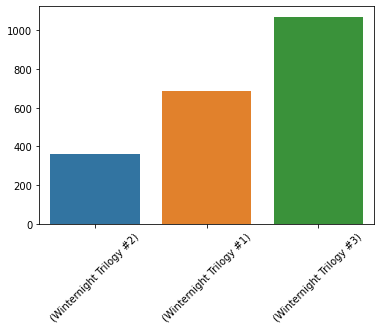

In [120]:

#considering only the rows containig the series of interest
new_df = df[df['bookseries_name'] == 'Winternight Trilogy']
new_df.reset_index(drop = True, inplace = True)

#sorting the dataset by the year
new_df.sort_values(['Year'], inplace =True)

x = new_df['bookSeries'].values #the x axis contains the years of publication
y = new_df['Pages'].values.cumsum() #the y axis contains the cumulative sum of the pages

sns.barplot(x=x,y=y)
plt.xticks(rotation=45)


plt.show

# 5. Algorithmic Question

In [18]:
#Given a string s as an input, this function returns the list of all subsequences in alphabetical order. 
#Then with max(l, key = len) we will return the length of the longest subsequence in alphabetical order.
def longest_sequence(s):
    if len(s)==1:
        return [s]
    else:
        l=longest_sequence(s[:len(s)-1])
        for e in l:
            if s[-1]>e[-1]:
                l.append(e+s[-1])
        l.append(s[-1])
        return l

### Some tests...

In [19]:
l = longest_sequence('CADFECEILGJHABNOFPSTIRYOEABILCNR')
max(l, key = len)

'CDFILNOPSTY'

In [20]:
s =  'azcbobobeghakl'
l = longest_sequence(s)
len(max(l,key = len))

7

In [21]:
l_2 = longest_sequence("CADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNR")
len(max(l_2,key = len))

16

### Running Time

###  Let's use simulation to find if time Versus len(string) is **exponential**

In [23]:
import timeit
from tqdm import tqdm
final_time_for_simulation = []
for k in tqdm(range(60, 100, 2)):
  time_of_simulation = []
  LCS_value = []
  for i in range(10):
    s = "".join(random.choices(string.ascii_lowercase, k = k))
    start = timeit.default_timer()
    l = longest_sequence(s)
    LCS_value.append(max(l, key = len))
    stop = timeit.default_timer()
    time_of_simulation.append(stop - start)  
  final_time_for_simulation.append(np.mean(time_of_simulation))

100%|██████████| 20/20 [06:23<00:00, 19.19s/it]


In [26]:
final_time_for_simulation

[0.17652730000118028,
 0.24686761000048135,
 0.14807195000103093,
 0.2341107699998247,
 0.39353709999923014,
 0.34881012999831,
 0.6748477600012848,
 0.6778793800003768,
 0.48102108999955817,
 0.7089887599991925,
 1.6281101300002774,
 1.720258389999799,
 2.2240570800015123,
 1.1697477999987314,
 1.5658612200022617,
 2.778010560001712,
 2.958590919998824,
 4.651481200000125,
 5.477151409997896,
 10.11106607000038]

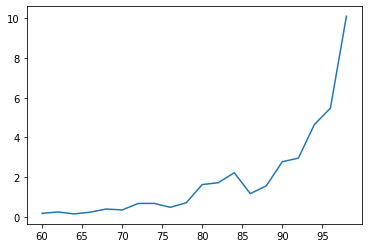

In [27]:
# PLot that shows exponential time required
import matplotlib.pyplot as plt
plt.plot(range(60, 100, 2),final_time_for_simulation)

In the worst case scenario when the new character is higher in alphabetic order than the latest character of every string in the list: <br>
When n=1 the list is empty and adds 1 <br>
When n=2 it checks 1 elements from the list and adds 1+1 <br>
When n=3 it checks 3 elements from the list and adds 3+1 <br>
When n=4 it checks 7 elements from the list and adds 7+1 <br>
When n=5 it checks 15 elements from the list and adds 15+1 <br>
So generally at every n >=2 it checks 2^(n-1)-1 elements (without even taking into account the recursive calls), therefore it's exponential <br>

## Use Dynamic Programming

During the course we have seen how to use dynamic programming to find the longest common subsequence of two string. We can use the same reasoning consider as strings our input s and the alphabet string "ABCDEFGHIJKLMNOPQRSTUVWXYZ".

In [6]:
def lcs_dynamic(s, alph):  
    n = len(s) 
    m = len(alph) 
    CS = [[None]*(m+1) for i in range(n+1)] 
    for i in range(n+1): 
        for j in range(m+1): 
            if i == 0 or j == 0 : 
                CS[i][j] = 0
            elif s[i-1] == alph[j-1]: 
                CS[i][j] = CS[i-1][j-1]+1
            else: 
                CS[i][j] = max(CS[i-1][j] , CS[i][j-1])
    return CS[n][m] 

### Some tests...

In [7]:
%%time
s = 'AZCBOBOBEGHAKL'
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
lcs_dynamic(s,alphabet)

Wall time: 0 ns


7

In [8]:
%%time
s = "CADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNRCADFECEILGJHABNOFPSTIRYOEABILCNR"
lcs_dynamic(s,alphabet)

Wall time: 5.06 ms


16

## Running Time
Since we have two nested for loops with costant running time operations the running time is $\theta(mn)$ where m and n are the lenghts of the strings considered.
In our case m has always the same value (24) so we can see our running time as $\theta(n)$.

# (last) BONUS

We can prove the formula by induction: <br>
1) Base Case : i = 1.<br>
&nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $X[1] = 1$ since there no exist such a j as requested

2) Induction Step: i→i+1. <br>
&nbsp;  We can observe that if there exist such  a j,
&nbsp; then $X[i+1] = 1+ X[i]$. <br>
&nbsp; Now we can use the inductive hypothesis and write:  <br>
&nbsp; $X[i+1] = 1+ 1+max\{X[j]; j=0,...,j=i-1 | S[j]<S[i]\}$ <br>
&nbsp; If we assume that exist such a j we get: <br>
&nbsp; $X[i+1] = 1+max\{X[j]; j=0,...,j=i | S[j]<S[i+1]\}$ <br>
That prove the formula.

$ \phi_k = 1-(\phi_1 + ...+ \phi_{k-1}) $